# Modelo de clasificacion de vino


Se Presenta una base de datos conocida como:\
 *1. Título de la base de datos: Datos de reconocimiento de vinos Actualizado el 21 de septiembre de 1998 por C. Blake: Se agregó información sobre atributos*

Fuente: \
(a) Forina, M. et al, PARVUS: un paquete extensible para exploración, clasificación y correlación de datos. Instituto de Análisis y Tecnologías Farmacéuticas y Alimentarias, Via Brigata Salerno,16147 Génova, Italia.\
(b) Stefan Aeberhard, correo electrónico: stefan@coral.cs.jcu.edu.au \
(c) julio de 1991

In [1]:
import os
from pathlib import Path

print("Actual path: ", os.getcwd())
os.chdir("..")
print("New path: ", os.getcwd())

Actual path:  /home/bdebian/Documents/Projects/tecnical_test_mvm/src/notebooks
New path:  /home/bdebian/Documents/Projects/tecnical_test_mvm/src


In [2]:
import time

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import psutil
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set_context("notebook")

Funciones de apoyo para el preprocesamiento de los datos donde:

__Función remove_outliers:__ 
- Esta función toma un DataFrame como entrada y devuelve un nuevo DataFrame sin outliers.
- Utiliza el método IQR (Interquartile Range) para identificar outliers.
- Los valores fuera del rango [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] se consideran outliers y se eliminan.

__Clase OutlierRemover:__ 
- Esta clase es un transformer personalizado para usar con pipelines de scikit-learn.
- El método fit es un método dummy que simplemente devuelve el objeto mismo.
- El método transform aplica la función remove_outliers a los datos de entrada y devuelve un array NumPy.

__Uso:__ 
- La función remove_outliers se puede usar directamente en un DataFrame.
- La clase OutlierRemover se puede usar en un pipeline de scikit-learn para aplicar la eliminación de outliers como parte de una secuencia de transformaciones.

In [3]:
def remove_outliers(sub_class: pd.DataFrame) -> pd.DataFrame:
    Q1 = sub_class.quantile(0.25)
    Q3 = sub_class.quantile(0.75)
    IQR = Q3 - Q1
    # mean_iqr = (Q1 + Q3) / 2
    data_out = sub_class[
        ~((sub_class < (Q1 - 1.5 * IQR)) | (sub_class > (Q3 + 1.5 * IQR)))
    ]
    return data_out

class OutlierRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return remove_outliers(pd.DataFrame(X)).values

El código define un pipeline de aprendizaje automático en Scikit-learn para realizar tareas de clasificación. Un pipeline combina múltiples pasos de procesamiento de datos y modelado en una secuencia única, lo que simplifica el flujo de trabajo y mejora la reproducibilidad.

Componentes del Pipeline:

__OutlierRemover__:

- Elimina los valores atípicos (outliers) de los datos utilizando el método IQR (Interquartile Range).
- Ayuda a prevenir que los outliers influyan negativamente en el entrenamiento del modelo.

__SimpleImputer__:

- Imputa los valores faltantes en los datos con la estrategia especificada (en este caso, la media).
- Garantiza que los datos estén completos antes de ser procesados por el modelo.

__MinMaxScaler__:

- Estandariza los datos a un rango específico (0-1).
- Ayuda a mejorar la convergencia del modelo y evita que las características con escalas diferentes dominen el entrenamiento.

__classifier__:

- Un marcador de posición para el clasificador que se utilizará.
- Se reemplazará con diferentes modelos y sus hiperparámetros durante la búsqueda de cuadrícula.

__Búsqueda de Parámetros__:

- param_grid define una lista de diccionarios que contienen diferentes combinaciones de modelos y sus hiperparámetros.
- Se explorarán diferentes modelos (Regresión Logística, SVM, Árbol de Decisión, Bosque Aleatorio) con diferentes configuraciones de hiperparámetros.

__Métricas de Evaluación__:

- scoring define un diccionario de métricas que se utilizarán para evaluar el rendimiento del modelo.
- Se incluyen métricas como precisión, F1-score y recall, lo que permite una evaluación completa del modelo.

In [4]:
# Definir los modelos y la búsqueda de parámetros
param_grid = [
    {
        "classifier": [LogisticRegression()],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.1, 1, 10],
        "classifier__solver": [
            "liblinear"
        ],  # Se requiere 'liblinear' para el uso de L1 en Logistic Regression
    },
    {
        "classifier": [SVC()],
        "classifier__kernel": ["linear", "rbf"],
        "classifier__C": [0.1, 1, 10],
    },
    {
        "classifier": [DecisionTreeClassifier()],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [None, 10, 20],
    },
    {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [50, 100, 200],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [None, 10, 30],
    },
]

# Crear la Pipeline
pipeline = Pipeline(
    [
        ("outlier_remover", OutlierRemover()),  # Remoción de outliers
        ("imputer", SimpleImputer(strategy="mean")),  # Imputación de valores faltantes
        ("scaler", MinMaxScaler()),  # Escalado de características
        ("classifier", LogisticRegression()),  # Placeholder para el clasificador
    ]
)

# Definir múltiples métricas para evaluar
scoring = {
    "accuracy": "accuracy",
    "f1_score": make_scorer(f1_score, average="weighted"),  # Promedio ponderado para clasificación multiclase
    "recall": make_scorer(recall_score, average="weighted"),
    # "roc_auc": "roc_auc_ovo",  # AUC para problemas multiclase (One-vs-One)
}

Procedemos a  cargar los datos desde memoria, donde le asignamos el nombre de las columnas

In [5]:
save_path = Path("data").joinpath("wine").with_suffix(".parquet")
columns = [
    "class",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline",
]
data = pd.read_parquet(save_path)
data.rename(columns=dict(zip(data.columns.values, columns)), inplace=True)

Esta parte del código se encarga de:

__Preparar los datos__: Dividiendo los datos en conjuntos de entrenamiento y prueba.
__Configurar la búsqueda de hiperparámetros__: Definiendo el espacio de búsqueda, el número de pliegues de validación cruzada y las métricas a utilizar.

__División de los Datos__
- __train_test_split__: Esta función divide el conjunto de datos completo X (características) e y (etiquetas) en dos conjuntos: uno para entrenamiento (X_train, y_train) y otro para prueba (X_test, y_test).
- __test_size__=0.2: Indica que el 20% de los datos se reservará para el conjunto de prueba.
- __random_state__=42: Establece una semilla aleatoria para garantizar la reproducibilidad de los resultados.
- __y_train__ = y_train.values.ravel(): Convierte las etiquetas y_train en un array unidimensional, lo cual es un requisito común para muchos algoritmos de clasificación.

__Configuración de GridSearchCV__
- __GridSearchCV__: Esta clase realiza una búsqueda exhaustiva de hiperparámetros en un espacio definido por el param_grid.
- __pipeline__: El pipeline creado anteriormente, que incluye preprocesamiento y el clasificador.
- __param_grid__: La lista de diccionarios con diferentes combinaciones de hiperparámetros para cada clasificador.
- __cv__=5: Se utiliza validación cruzada de 5 pliegues para evaluar el rendimiento de cada combinación de hiperparámetros.
- __n_jobs__=-1: Utiliza todos los núcleos de la CPU disponibles para acelerar la búsqueda.
- __verbose__=2: Muestra información detallada sobre el progreso de la búsqueda.
- __scoring__=scoring: Utiliza el diccionario de métricas definido anteriormente para evaluar el rendimiento del modelo.
- __refit__="accuracy": Después de la búsqueda, el mejor modelo se vuelve a entrenar utilizando todos los datos de entrenamiento y la combinación de hiperparámetros que obtuvo la mayor precisión.

In [6]:
X = data[columns[1:]]
y = data[columns[:1]]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Asegurar que y_train es un array 1D
y_train = y_train.values.ravel()

# Configurar GridSearchCV para explorar los hiperparámetros
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring, refit="accuracy"
)

In [8]:
mlflow.login()

2024/08/23 04:42:42 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


La siguente etapa es la de entranamiento y evaluacion del los modelo para la clasificacion

**1. Iniciar la Ejecución y Registrar Recursos:**

* Inicia una ejecución de MLflow y registra el uso de CPU y memoria.

**2. Entrenar el Modelo:**

* Realiza una búsqueda de parámetros utilizando GridSearchCV para encontrar la mejor combinación para la pipeline.
* Guarda el mejor modelo encontrado.

**3. Evaluar el Modelo en Test y Registrar Resultados:**

* Evalúa el modelo con el mejor rendimiento en el conjunto de prueba.
* Calcula métricas como precisión, F1-score y recall.
* Registra estas métricas y parámetros del modelo en MLflow.
* Imprime el rendimiento del modelo.
* Registra el tiempo de entrenamiento en MLflow.

**4. Generar y Registrar Matriz de Confusión:**

* Crea una matriz de confusión para visualizar el rendimiento del modelo.
* Guarda la matriz como imagen y la registra en MLflow.

**5. Almacenar el Modelo en MLflow:**

* Registra el mejor modelo entrenado en MLflow para su uso posterior.

**6. Evaluar el Modelo Usando MLflow (Opcional):**

* Evalúa nuevamente el modelo con datos de prueba utilizando la API de evaluación de MLflow.
* Registra los resultados y métricas de esta evaluación.

**7. Analizar Rendimiento por Métrica:**

* Recorre las métricas seleccionadas (F1-score, precisión, recall).
* Para cada métrica:
    * Filtra los resultados de la búsqueda de parámetros.
    * Ordena los resultados por la mejor clasificación.
    * Selecciona las 10 mejores configuraciones.
    * Guarda los resultados en un archivo Parquet.
    * Registra el archivo Parquet en MLflow.
    * Crea un gráfico de barras para comparar los modelos según la métrica.
    * Guarda el gráfico como imagen y la registra en MLflow.

**8. Predecir en Datos de Ejemplo:**

* Crea un DataFrame de ejemplo con el mismo formato que los datos originales.
* Utiliza el modelo entrenado para predecir la clase para cada punto de datos en el ejemplo.
* Agrega las predicciones al DataFrame de ejemplo y lo guarda como un archivo CSV.
* Registra el archivo CSV en MLflow.


2024/08/23 04:42:42 INFO mlflow.tracking.fluent: Experiment with name '/Users/brayanfz013@gmail.com/model_mvm' does not exist. Creating a new experiment.


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s

[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV]

2024/08/23 04:42:58 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.15.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.
2024/08/23 04:43:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
/home/bdebian/.virtualenvs/mvm_test/lib/python3.12/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample 

,param_classifier,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,params
18,RandomForestClassifier(),0.985772,0.017425,1,"{'classifier': RandomForestClassifier(), 'clas..."
32,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
21,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
34,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
25,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
31,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
29,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
5,LogisticRegression(),0.971946,0.014035,8,"{'classifier': LogisticRegression(), 'classifi..."
26,RandomForestClassifier(),0.971334,0.027183,9,"{'classifier': RandomForestClassifier(), 'clas..."
3,LogisticRegression(),0.971334,0.027183,9,"{'classifier': LogisticRegression(), 'classifi..."


,param_classifier,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,params
18,RandomForestClassifier(),0.985714,0.017496,1,"{'classifier': RandomForestClassifier(), 'clas..."
32,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
21,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
34,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
25,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
31,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
29,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
5,LogisticRegression(),0.971921,0.014050,8,"{'classifier': LogisticRegression(), 'classifi..."
26,RandomForestClassifier(),0.971675,0.026665,9,"{'classifier': RandomForestClassifier(), 'clas..."
3,LogisticRegression(),0.971675,0.026665,9,"{'classifier': LogisticRegression(), 'classifi..."


,param_classifier,mean_test_recall,std_test_recall,rank_test_recall,params
18,RandomForestClassifier(),0.985714,0.017496,1,"{'classifier': RandomForestClassifier(), 'clas..."
32,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
21,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
34,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
25,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
31,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
29,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
5,LogisticRegression(),0.971921,0.014050,8,"{'classifier': LogisticRegression(), 'classifi..."
26,RandomForestClassifier(),0.971675,0.026665,9,"{'classifier': RandomForestClassifier(), 'clas..."
3,LogisticRegression(),0.971675,0.026665,9,"{'classifier': LogisticRegression(), 'classifi..."


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,prediction_class
0,13.72,1.43,2.50,16.7,108,3.40,3.67,0.19,2.04,6.80,0.89,2.87,1285,1
1,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520,2


2024/08/23 04:43:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-crane-51 at: https://community.cloud.databricks.com/ml/experiments/165096498651139/runs/e3aa074bb9e64577ae813c7909ba88d8.
2024/08/23 04:43:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/165096498651139.


<Figure size 1000x700 with 0 Axes>

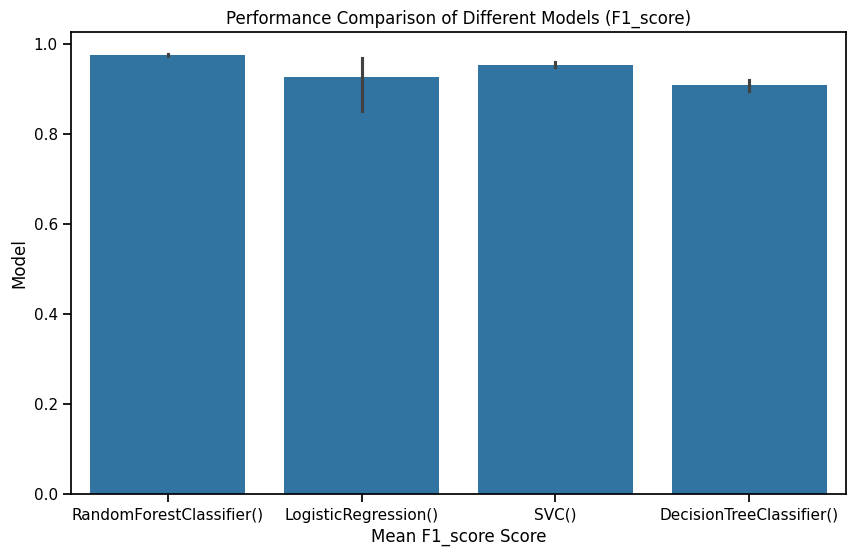

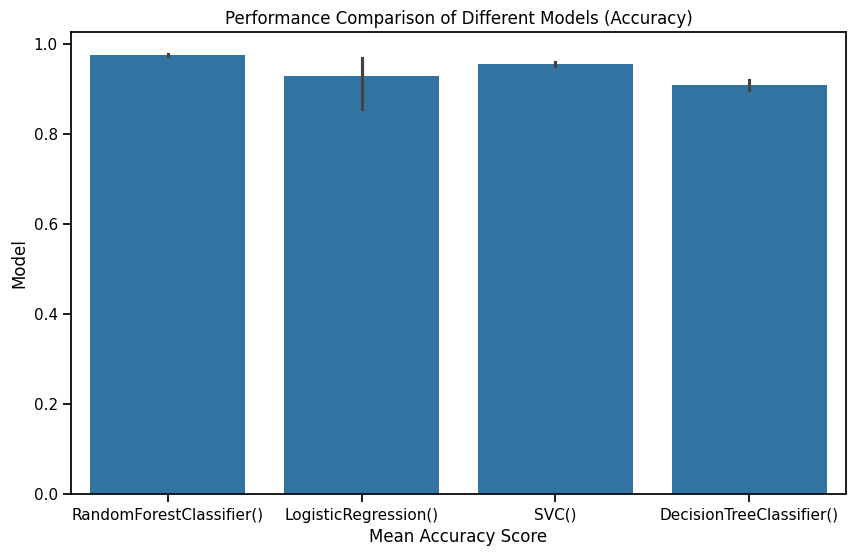

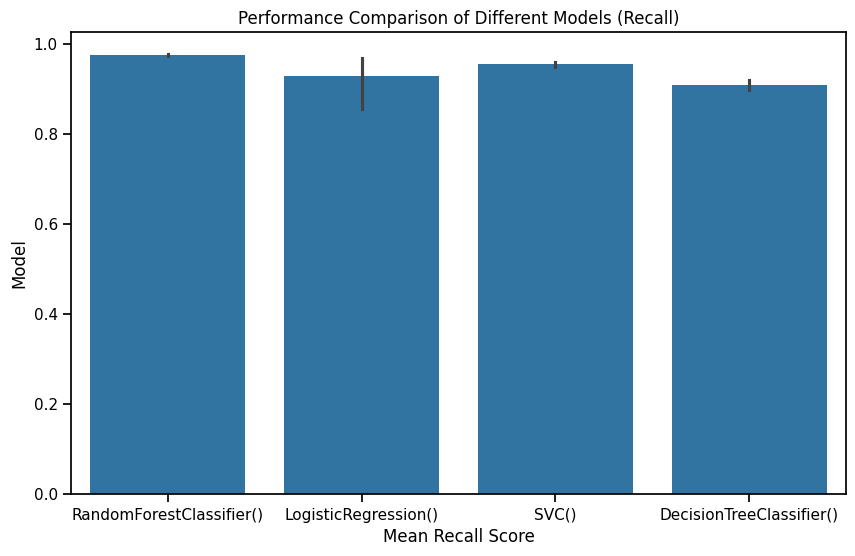

In [9]:
mlflow.set_experiment("/Users/brayanfz013@gmail.com/model_mvm")

with mlflow.start_run():

    start_time = time.time()
    mlflow.log_metric("cpu_usage", psutil.cpu_percent())
    mlflow.log_metric("memory_usage", psutil.virtual_memory().percent)

    # Entrenar la pipeline con la búsqueda de parámetros
    grid_search.fit(X_train, y_train)

    # Evaluar el mejor modelo en el conjunto de prueba
    best_model = grid_search.best_estimator_
    mlflow.log_param("Mejor modelo encontrado:", grid_search.best_params_)
    mlflow.log_param("Precisión en test:", best_model.score(X_test, y_test))

    y_pred = best_model.predict(X)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred)
    mlflow.log_text(class_report, "classification_report.txt")

    # Calcular las métricas
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="weighted")
    recall = recall_score(y, y_pred, average="weighted")

    # Registrar los parámetros y las métricas en MLflow
    mlflow.log_param(
        "best_model_type", type(best_model.named_steps["classifier"]).__name__
    )
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("recall", recall)

    print("Modelo registrado en MLflow con las métricas:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")

    end_time = time.time()
    training_duration = end_time - start_time
    mlflow.log_metric("training_duration", training_duration)

    # Guardar la matriz de confusión como imagen
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    mlflow.sklearn.log_model(best_model, "best_model_pipeline")
    model_uri = mlflow.get_artifact_uri("best_model_pipeline")

    eval_data = X_test.copy()
    eval_data["class"] = y_test
    # Evaluar el modelo usando mlflow.evaluate
    eval_results = mlflow.evaluate(
        model=model_uri,
        data=eval_data,  # (X_test, y_test),
        targets="class",  # "auto" detecta automáticamente la columna objetivo
        model_type="classifier",  # Especifica el tipo de modelo (regressor o classifier)
        evaluator_config={
            "metric_prefix": "test_",  # Prefijo para las métricas
            "log_model": True,  # Registrar nuevamente el modelo evaluado
            "artifacts": ["confusion_matrix"],
        },
    )

    results = pd.DataFrame(grid_search.cv_results_)

    metrics = {
        "f1_score": "mean_test_f1_score",
        "accuracy": "mean_test_accuracy",
        "recall": "mean_test_recall",
    }

    #Ciclo para evaluar cada metricas seleccionada
    for metric_name, metric_column in metrics.items():
        results_summary = results[
            [
                "param_classifier",
                metric_column,
                f"std_test_{metric_name}",
                f"rank_test_{metric_name}",
                "params",
            ]
        ]

        results_summary = results_summary.sort_values(by=f"rank_test_{metric_name}")
        results_summary_temp = results_summary.head(10)
        display(results_summary_temp)
        results_summary_temp.to_csv(f"{metric_name}.parquet", index=False)
        mlflow.log_artifact(f"{metric_name}.parquet")

        plt.figure(figsize=(10, 6))
        sns.barplot(
            x=results_summary["param_classifier"].astype(str),
            y=results_summary[metric_column],
        )
        plt.xlabel(f"Mean {metric_name.capitalize()} Score")
        plt.ylabel("Model")
        plt.title(
            f"Performance Comparison of Different Models ({metric_name.capitalize()})"
        )
        plt.savefig(f"rank_test_{metric_name}.png")
        mlflow.log_artifact(f"rank_test_{metric_name}.png")

    #Eval data custom MVM
    eval_custom = pd.DataFrame(
        [
            [
                13.72,
                1.43,
                2.5,
                16.7,
                108,
                3.4,
                3.67,
                0.19,
                2.04,
                6.8,
                0.89,
                2.87,
                1285,
            ],
            [
                12.37,
                0.94,
                1.36,
                10.6,
                88,
                1.98,
                0.57,
                0.28,
                0.42,
                1.95,
                1.05,
                1.82,
                520,
            ],
        ],
        columns=columns[1:],
    )

    result = []
    for _, data_i in eval_custom.iterrows():
        data_pred = [list(data_i.values)]
        result.append(best_model.predict(data_pred)[0])

    eval_custom["prediction_class"] = result
    eval_custom.to_csv("data_demo.csv", index=False)
    display(eval_custom)
    # Registrar el archivo CSV como un artifact
    mlflow.log_artifact("data_demo.csv")

## Desglosando el codigo anterior

omitiendo la parte de MLflow para un entendimiento en local de los resultado se obtiene que el mejor modelo despues de realizar la cuadricula de entramiento y parametros fue:

```json
Mejor modelo encontrado: {
    'classifier': RandomForestClassifier(), 
    'classifier__criterion': 'entropy', 
    'classifier__max_depth': 10, 
    'classifier__n_estimators': 100
    }
Precisión en test: 1.0

```

In [10]:
# Entrenar la pipeline con la búsqueda de parámetros
grid_search.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

print("Mejor modelo encontrado:", grid_search.best_params_)
print("Precisión en test:", best_model.score(X_test, y_test))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s


Visualizando los resultado en la matriz de confucion para los datos esta muestra una comparación entre los valores reales y los valores predichos por el modelo. Cada celda de la matriz representa una combinación de una clase real y una clase predicha.

Donde se evidencia que:

- El modelo ha clasificado correctamente todas las muestras.
- No hay falsos positivos ni falsos negativos.
- Todas las muestras fueron asignadas a la clase correcta.

ademas de las metricas de evaluacion para el modelo se tiene que :

- __Accuracy (Precisión):__ La proporción total de predicciones correctas. En este caso, el modelo clasificó correctamente todas las muestras, por lo que la precisión es 1.0.
- __F1-Score:__ La media armónica de precisión y recall. Un valor de 1.0 indica un rendimiento perfecto.
- __Recall (Sensibilidad):__ La proporción de muestras positivas que fueron correctamente identificadas como positivas. Al igual que la precisión, el recall es 1.0 en este caso, lo que significa que todas las muestras positivas fueron correctamente clasificadas.

Accuracy: 1.0
F1 Score: 1.0
Recall: 1.0


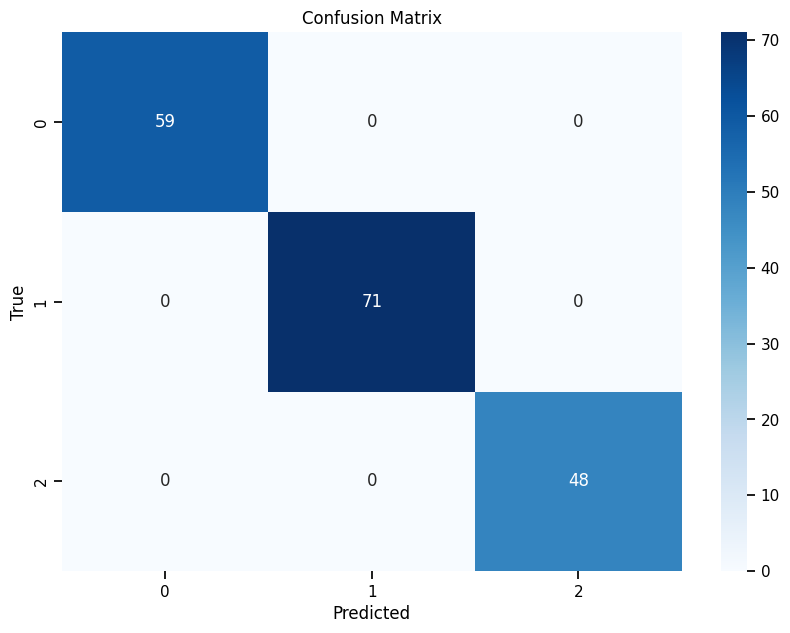

In [11]:
# Calcular la matriz de confusión
cm = confusion_matrix(y, y_pred)
class_report = classification_report(y, y_pred)

# Calcular las métricas
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average="weighted")
recall = recall_score(y, y_pred, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

# Guardar la matriz de confusión como imagen
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Ademas se evaluarion las siguientes metricas de en los diferente tipos de modelo (Regresión Logística, SVM, Árbol de Decisión, RandomForestClassifier)
```python
metrics = {
    "f1_score"
    "accuracy"
    "recall"
}
```

En cada metricas predominaba el RandomForestClassifier pero igualmente se hace un grafica comparativa de los resultados de los diferentes modelo y entrenamiento a lo largo de las 3 metricas para tipo de modelo propuesto, aunque el rendimiento que se observa es similiar predomina el RandomForestClassifier.

El modelo puestro numero 1, es decir el modelo con mas puntaje para cada metrica se repartio asi :
- __f1_score__ :  RandomForestClassifier   =  0.985794
- __accuracy__: RandomForestClassifier   =  0.985714
- __recall__:  RandomForestClassifier   =  0.985714

,param_classifier,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,params
31,RandomForestClassifier(),0.985794,0.017398,1,"{'classifier': RandomForestClassifier(), 'clas..."
29,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
25,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
23,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
32,RandomForestClassifier(),0.978295,0.029107,2,"{'classifier': RandomForestClassifier(), 'clas..."
5,LogisticRegression(),0.971946,0.014035,6,"{'classifier': LogisticRegression(), 'classifi..."
3,LogisticRegression(),0.971334,0.027183,7,"{'classifier': LogisticRegression(), 'classifi..."
26,RandomForestClassifier(),0.971334,0.027183,7,"{'classifier': RandomForestClassifier(), 'clas..."
22,RandomForestClassifier(),0.971334,0.027183,7,"{'classifier': RandomForestClassifier(), 'clas..."
21,RandomForestClassifier(),0.971334,0.027183,7,"{'classifier': RandomForestClassifier(), 'clas..."


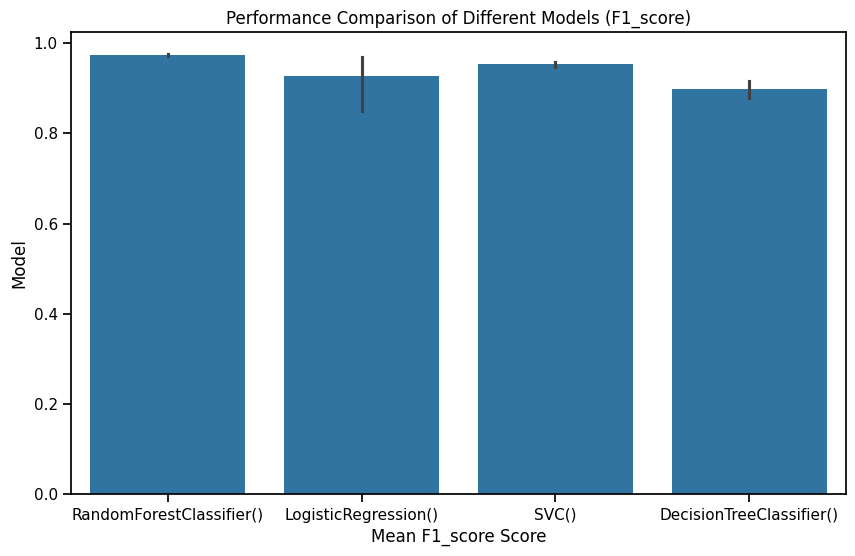

,param_classifier,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,params
31,RandomForestClassifier(),0.985714,0.017496,1,"{'classifier': RandomForestClassifier(), 'clas..."
25,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
23,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
29,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
32,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
5,LogisticRegression(),0.971921,0.014050,6,"{'classifier': LogisticRegression(), 'classifi..."
26,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."
34,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."
22,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."
21,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."


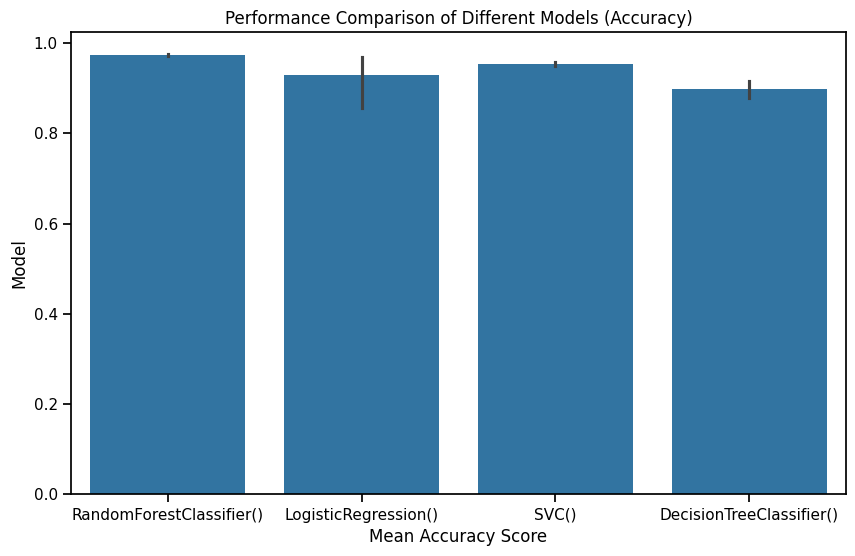

,param_classifier,mean_test_recall,std_test_recall,rank_test_recall,params
31,RandomForestClassifier(),0.985714,0.017496,1,"{'classifier': RandomForestClassifier(), 'clas..."
25,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
23,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
29,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
32,RandomForestClassifier(),0.978571,0.028571,2,"{'classifier': RandomForestClassifier(), 'clas..."
5,LogisticRegression(),0.971921,0.014050,6,"{'classifier': LogisticRegression(), 'classifi..."
26,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."
34,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."
22,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."
21,RandomForestClassifier(),0.971675,0.026665,7,"{'classifier': RandomForestClassifier(), 'clas..."


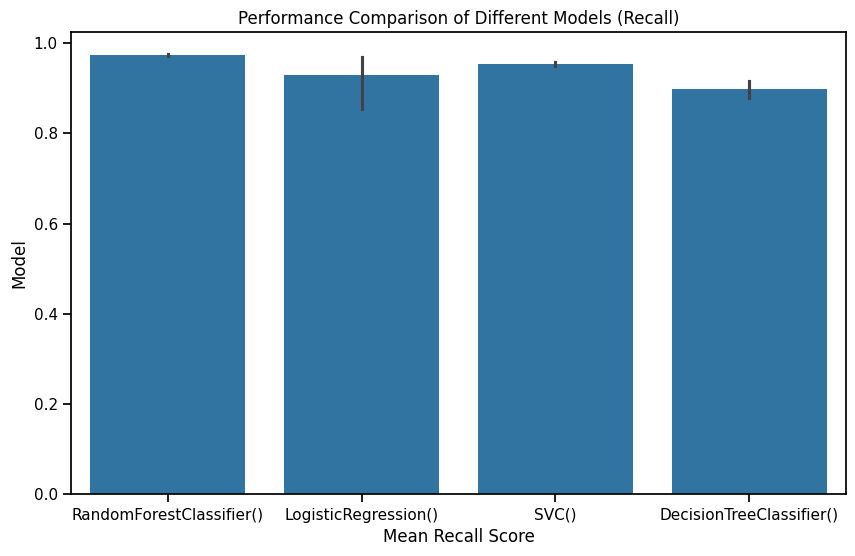

In [12]:
results = pd.DataFrame(grid_search.cv_results_)

metrics = {
    "f1_score": "mean_test_f1_score",
    "accuracy": "mean_test_accuracy",
    "recall": "mean_test_recall",
}

#Ciclo para evaluar cada metricas seleccionada
for metric_name, metric_column in metrics.items():
    results_summary = results[
        [
            "param_classifier",
            metric_column,
            f"std_test_{metric_name}",
            f"rank_test_{metric_name}",
            "params",
        ]
    ]

    results_summary = results_summary.sort_values(by=f"rank_test_{metric_name}")
    results_summary_temp = results_summary.head(20)
    display(results_summary_temp)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=results_summary["param_classifier"].astype(str),
        y=results_summary[metric_column],
    )
    plt.xlabel(f"Mean {metric_name.capitalize()} Score")
    plt.ylabel("Model")
    plt.title(
        f"Performance Comparison of Different Models ({metric_name.capitalize()})"
    )
    plt.show()

Para evaluar los datos personalizado propuestos por el realizador en el mejor modelo se tiene que:

```python
[13.72,1.43,2.5,16.7,108,3.4,3.67,0.19,2.04,6.8,0.89,2.87,1285]   Pertenece a la clase 1
[12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520]  Pertenece a la clase 2
```

In [13]:
#Eval data custom MVM
eval_custom = pd.DataFrame(
    [
        [
            13.72,
            1.43,
            2.5,
            16.7,
            108,
            3.4,
            3.67,
            0.19,
            2.04,
            6.8,
            0.89,
            2.87,
            1285,
        ],
        [
            12.37,
            0.94,
            1.36,
            10.6,
            88,
            1.98,
            0.57,
            0.28,
            0.42,
            1.95,
            1.05,
            1.82,
            520,
        ],
    ],
    columns=columns[1:],
)

result = []
for _, data_i in eval_custom.iterrows():
    data_pred = [list(data_i.values)]
    result.append(best_model.predict(data_pred)[0])

eval_custom["prediction_class"] = result
eval_custom.to_csv("data_demo.csv", index=False)
display(eval_custom)


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,prediction_class
0,13.72,1.43,2.50,16.7,108,3.40,3.67,0.19,2.04,6.80,0.89,2.87,1285,1
1,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520,2
